In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from keras import backend as K
from tensorflow import keras
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import pickle

np.set_printoptions(precision=3, suppress=True)

Using TensorFlow backend.


In [84]:
COLUMN_NAMES = ["dim1", "dim2", "dim3", "dim4", 
                "dim5", "dim6", "dim7", "dim8", 
                "dim9", "dim10", "label"]
LABEL_NAME = "label"
INPUT_NAMES = list(COLUMN_NAMES)
INPUT_NAMES.remove(LABEL_NAME)
trajectory_list = pickle.load(open("N-Dim_Doublewell/trajectory_list.p", "rb"))
trajectory_label_list = pickle.load(open("N-Dim_Doublewell/trajectory_label_list.p", "rb"))
snapshot_list = pickle.load(open("N-Dim_Doublewell/snapshot_list.p", "rb"))
snapshot_label_list = pickle.load(open("N-Dim_Doublewell/snapshot_label_list.p", "rb"))
snapshot_progress_label_list = pickle.load(open("N-Dim_Doublewell/snapshot_progress_label_list.p", "rb"))
BATCH_SIZE = 2
SHUFFLE_BUFFER_SIZE = 10000
CORES_USED = 3
# Sets a split size for train and test data set
TRAJ_TRAIN_SIZE = int(len(trajectory_label_list) * 0.7)
SNAP_TRAIN_SIZE = int(len(snapshot_label_list) * 0.7)
# sets a random seed for reproducibility of the shuffling process
SEED = 5



In [108]:
# additional section can be used for generation of present/future pairs

OFFSET = 5
def generate_offset_snapshot_list(trajectory_list, offset):
    # Takes in a list or np.array of trajectories and an offset value and generates two np.arrays with respective new versions
    # of the trajectories. 
    # present_trajectory_list contains all snapshots of the trajectories excluding
    # the last n (speficified by offset) of each.
    # future_trajectory_list contains all snapshots of the trajectories excluding
    # the first n (specified by offset) of each.
    # Consequently the both lists can be used as input and desired output of an autoencoder to
    # train for future predictive variables.
    present_trajectory_list = np.array([trajectory[:-offset] for trajectory in trajectory_list])  
    #truncated_present_trajectory_list = 
    future_trajectory_list = np.array([trajectory[offset:] for trajectory in trajectory_list])
    return present_trajectory_list, future_trajectory_list

def get_snapshot_and_label_list(trajectory_list, trajectory_label_list, offset = 0, future = False):
    # takes in a list of trajectories and corresponding labels and generates concatenated lists of snapshots, 
    # snapshot label and snapshot progress labels
    # can be used for present/future trajcetory lists by use or offset (same as used for generation of the list)
    # and future = True for the future trajectory list
    snapshot_list = []
    snapshot_label_list = []
    snapshot_progress_label_list = []
    for trajectory_nr in range(len(trajectory_list)):
        trajectory = trajectory_list[trajectory_nr]
        trajectory_label = trajectory_label_list[trajectory_nr]
        for snapshot_nr in range(len(trajectory)):
            snapshot_list.append(trajectory[snapshot_nr])
            snapshot_label_list.append(trajectory_label)
            # Calculates the progress along the path for AB paths. If the path label is 1 or 0,
            # all snapshot are assigned the same label. If the path label is different (e.g. 0.5),
            # indicating a sucessfull transition a progress along the snapshots is calculated based on
            # the position within the trajectory and the total trajectory length.
            # For present/future lists, the offset needs to be taken into account in the denominator
            # If the dataset is a future variant of an offset trajectory list the progress label 
            # needs to additionally take the offset into account in the nominator.
            if trajectory_label == 0.0 or trajectory_label == 1.0:
                snapshot_progress_label_list.append(trajectory_label)
            else:
                if future == True:
                    snapshot_progress_label_list.append((snapshot_nr + offset)/(len(trajectory) - 1.0 + offset))
                else:
                    snapshot_progress_label_list.append(snapshot_nr/(len(trajectory)-1.0 + offset))
    return np.array(snapshot_list), np.array(snapshot_label_list), np.array(snapshot_progress_label_list)

#present_trajectory_list, future_trajectory_list = generate_offset_snapshot_list(trajectory_list, OFFSET)

#present_snapshot_list, present_snapshot_label_list, present_snapshot_progress_label_list = get_snapshot_and_label_list(
#    present_trajectory_list, trajectory_label_list, OFFSET)
#future_snapshot_list, future_snapshot_label_list, future_snapshot_progress_label_list = get_snapshot_and_label_list(
#    future_trajectory_list, trajectory_label_list, OFFSET, future = True)

In [109]:
snapshot_list, snapshot_label_list, snapshot_progress_label_list = get_snapshot_and_label_list(
    trajectory_list, trajectory_label_list)
s_ds = tf.data.Dataset.from_tensor_slices(snapshot_list)
sl_ds = tf.data.Dataset.from_tensor_slices(snapshot_label_list)
spl_ds = tf.data.Dataset.from_tensor_slices(snapshot_progress_label_list)

train_s_ds = s_ds.take(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
test_s_ds = s_ds.skip(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
train_sl_ds = sl_ds.take(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
test_sl_ds = sl_ds.skip(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
train_spl_ds = spl_ds.take(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
test_spl_ds = spl_ds.skip(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
took1 = train_s_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_sl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_spl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)

[[-0.342  0.113 -0.935 -0.131 -0.17   0.022 -0.276  0.439 -0.419  0.216]
 [-0.332  0.118  0.344  0.701 -0.398  0.161  0.502  0.995 -0.478  0.624]]
[0. 0.]
[0. 0.]


In [126]:
s_ds = tf.data.Dataset.from_tensor_slices(snapshot_list)
sl_ds = tf.data.Dataset.from_tensor_slices(snapshot_label_list)
spl_ds = tf.data.Dataset.from_tensor_slices(snapshot_progress_label_list)

train_s_ds = s_ds.take(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
test_s_ds = s_ds.skip(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
train_sl_ds = sl_ds.take(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
test_sl_ds = sl_ds.skip(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
train_spl_ds = spl_ds.take(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
test_spl_ds = spl_ds.skip(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)


ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": snapshot_list},
                                        {"label":snapshot_label_list, "reconstruction":snapshot_list}))
"""train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'img_input': img_data, 'ts_input': ts_data},
     {'score_output': score_targets, 'class_output': class_targets}))
"""

train_ds = ds.take(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)
test_ds = ds.skip(SNAP_TRAIN_SIZE).batch(BATCH_SIZE)

In [127]:
took1 = train_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)

({'input_snapshots': array([[-0.342,  0.113, -0.935, -0.131, -0.17 ,  0.022, -0.276,  0.439,
        -0.419,  0.216],
       [-0.332,  0.118,  0.344,  0.701, -0.398,  0.161,  0.502,  0.995,
        -0.478,  0.624]])}, {'label': array([0., 0.]), 'reconstruction': array([[-0.342,  0.113, -0.935, -0.131, -0.17 ,  0.022, -0.276,  0.439,
        -0.419,  0.216],
       [-0.332,  0.118,  0.344,  0.701, -0.398,  0.161,  0.502,  0.995,
        -0.478,  0.624]])})


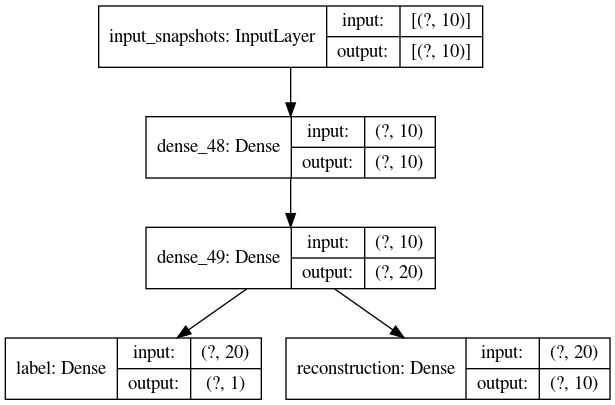

In [128]:
import pydot
%matplotlib notebook
input_snapshots = keras.Input(shape=(len(INPUT_NAMES),),name="input_snapshots")
x = keras.layers.Dense(len(INPUT_NAMES))(input_snapshots)
x = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
output_1 = keras.layers.Dense(1, activation='tanh',name="label")(x)
output_2 = keras.layers.Dense(len(INPUT_NAMES), activation='tanh',name="reconstruction")(x)

model = keras.Model(inputs=input_snapshots,outputs=[output_1,output_2])
model_layout = keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)
display.display(model_layout)

In [129]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'label':keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      'reconstruction': keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
              loss_weights=[1., 0.2])

In [130]:
took1 = train_s_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_sl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_spl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)

[[-0.342  0.113 -0.935 -0.131 -0.17   0.022 -0.276  0.439 -0.419  0.216]
 [-0.332  0.118  0.344  0.701 -0.398  0.161  0.502  0.995 -0.478  0.624]]
[0. 0.]
[0. 0.]


[-0.342  0.113 -0.935 -0.131 -0.17   0.022 -0.276  0.439 -0.419  0.216]
[-0.332  0.118  0.344  0.701 -0.398  0.161  0.502  0.995 -0.478  0.624]
[-0.324  0.122  0.108 -0.326 -0.06  -0.547  0.957  0.993  0.825  0.955]
0.0
0.0
0.0
0.0
0.0
0.0
(230563, 10) (230563,)


In [134]:
model.fit(train_ds,
          epochs=2)


Train for 80697 steps
Epoch 1/2
    1/80697 [..............................] - ETA: 7:04:15

InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [2,10] and labels shape [20]
	 [[node loss/reconstruction_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-134-ce3fb8cee530>:2) ]] [Op:__inference_distributed_function_8435]

Function call stack:
distributed_function


In [ ]:
took1 = train_s_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_sl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_spl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(len(INPUT_NAMES),input_shape=(len(INPUT_NAMES),)),
    tf.keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh'),
    tf.keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh'),
    tf.keras.layers.Dense(2, activation='tanh'),
    tf.keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh'),
    tf.keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh'),
    tf.keras.layers.Dense(len(INPUT_NAMES))])

model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanSquaredError()])
tf.print

model.fit(train_ss_ds, epochs=1)



Train for 80305 steps
80305/80305 [==============================] - 99s 1ms/step - loss: 0.2098 - mean_squared_error: 0.2098


In [37]:
# accessing the output of all layers

features_list = [layer.output for layer in model.layers]
print(features_list)
feat_extraction_model = keras.Model(inputs=model.input, outputs=features_list)

img = np.random.random((1,10)).astype('float32')
extracted_features = feat_extraction_model(img)
print(extracted_features)

[<tf.Tensor 'dense_27/Identity:0' shape=(None, 10) dtype=float32>, <tf.Tensor 'dense_28/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_29/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_30/Identity:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'dense_31/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_32/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_33/Identity:0' shape=(None, 10) dtype=float32>]
[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.273, -0.464, -0.47 , -0.025,  0.037, -0.45 ,  0.029, -0.035,
         0.116, -0.016]], dtype=float32)>, <tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[-0.071,  0.101,  0.009,  0.008,  0.018,  0.043, -0.004,  0.001,
        -0.091, -0.01 ,  0.096,  0.019, -0.009, -0.181,  0.02 ,  0.156,
        -0.202, -0.011, -0.004, -0.015]], dtype=float32)>, <tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[-0.002,  0.002,  0.187, -0.023,  0.001,  0.135, -0.003,  0.   ,


In [129]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_24 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_25 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 42        
_________________________________________________________________
dense_27 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_28 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_29 (Dense)             (None, 10)               

In [130]:
example_batch, label_batch = next(iter(train_sl_ds))    


# with a Sequential model
output = K.function([model.layers[0].input],
                    [model.layers[3].output])
layer_output = output(example_batch)[0]
'''''''''''''''''''''''''''''''Do Stuff'
#print(output)
print(example_batch[0][:2])
print(layer_output[0])
print(label_batch[0])

tf.Tensor([0.673 0.176], shape=(2,), dtype=float64)
[-0.088  0.085]
tf.Tensor(1.0, shape=(), dtype=float64)


In [131]:
test_loss, test_acc = model.evaluate(test_ss_ds, verbose=1, steps = 200)

200/200 [==============================] - 0s 1ms/step - loss: 0.2169 - mean_squared_error: 0.2169


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()
